In [1]:
from __future__ import annotations

import os
from dotenv import load_dotenv
from stonks.data_preprocessing import Client

load_dotenv()
API_KEY = os.getenv("POLYGON_API_KEY")
client = Client(API_KEY)

Below, we begin to pull in data for a specified stock ticker. We pull in data from Polygon.io using an API_KEY. 
* The API_KEY is stored in a *.env* file that was ignored when we push everything to Github, just to ensure best practices.

The code in the following cell does some cleaning. It filters out contracts that do not have any greeks. Additionally, we are only pulling in options contracts for a given time frame according to the default values we have established. Our goal is to return a dataframe of contracts that can be analyzed.

In [ ]:
ticker = "AAL"
contracts = client.get_option_contracts(ticker)
historial_stock_data = client.get_price_history(ticker)

In [ ]:
historial_stock_data.head()

,volume,vw,open,close,high,low,timestamp,n
0,19455166.0,14.6810,14.66,14.73,14.825,14.57,2023-08-28 04:00:00,60425
1,22186448.0,14.9023,14.74,14.90,14.990,14.69,2023-08-29 04:00:00,64739
2,19981093.0,14.8457,14.93,14.77,14.950,14.76,2023-08-30 04:00:00,55934
3,13994479.0,14.7667,14.89,14.73,14.915,14.68,2023-08-31 04:00:00,47985
4,14755517.0,14.6763,14.80,14.68,14.840,14.59,2023-09-01 04:00:00,51594


Lets further look at the actual stock movement of a given ticker symbol

In [21]:
!uv pip install seaborn

Using Python 3.12.9 environment at: /Users/michaelkovacevich/proj/stonks/.hatch/stonks-dev
Resolved 15 packages in 220ms                                        
Installed 1 package in 16ms                                 
 + seaborn==0.13.2


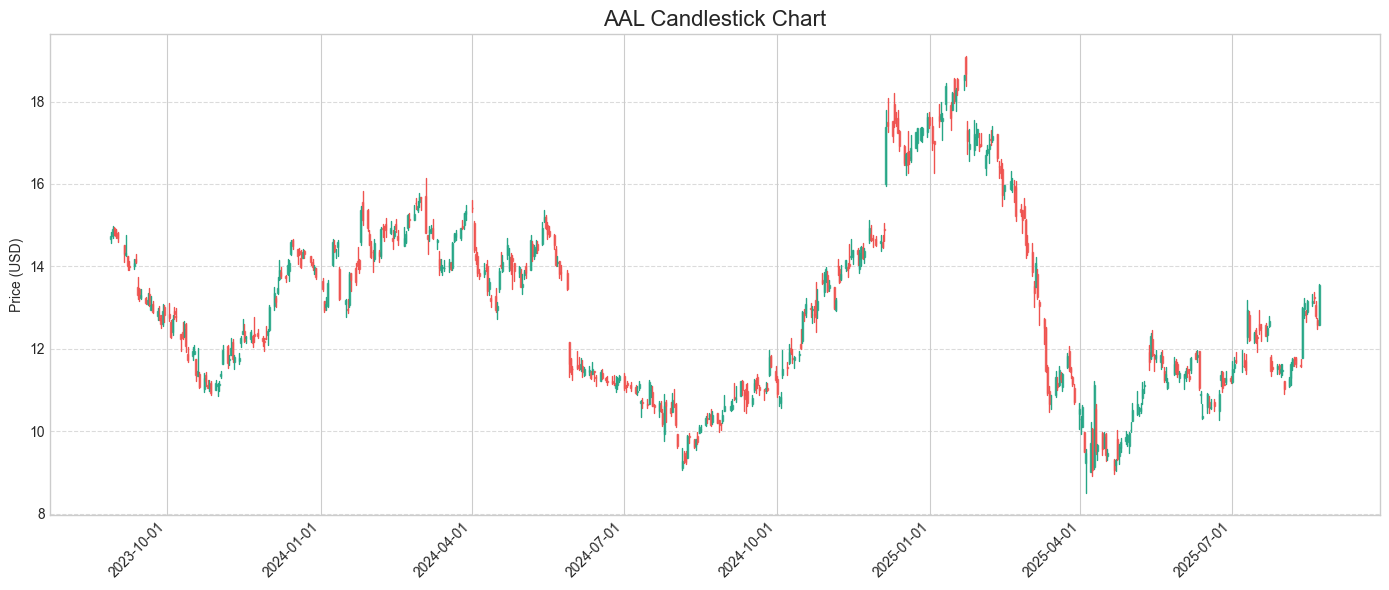

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

up_color = "#26a686"
down_color = "#ef5350"

historial_stock_data["timestamp"] = pd.to_datetime(historial_stock_data["timestamp"])

fig, ax = plt.subplots(figsize=(14, 6))

for _, row in historial_stock_data.iterrows():
    color = up_color if row["close"] >= row["open"] else down_color


    ax.plot([row["timestamp"], row["timestamp"]], [row["low"], row["high"]], color=color, linewidth=1)

   
    ax.add_patch(
        plt.Rectangle(
            (mdates.date2num(row["timestamp"] - pd.Timedelta(hours=7.2)),  # slightly narrower
             min(row["open"], row["close"])),
            width=0.6,
            height=abs(row["close"] - row["open"]),
            color=color,
            alpha=0.8
        )
    )

# Format x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45, ha="right")

# Grid, labels, title
ax.set_title(f"{ticker} Candlestick Chart", fontsize=16)
ax.set_ylabel("Price (USD)")
ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
from __future__ import annotations

def compute_indicators(
    df: pd.DataFrame,
    price_col: str = "vw",
    window_short: int = 10,
    window_long: int = 50,
    sharpe_windows: list[int] = [20, 60, 120]
) -> pd.DataFrame:
    df = df.copy()
    price = df[price_col]

    # Returns & moving averages
    df["ret_1"] = price.pct_change()
    df["sma_short"] = price.rolling(window_short, min_periods=1).mean()
    df["sma_long"] = price.rolling(window_long, min_periods=1).mean()
    df["ema_short"] = price.ewm(span=window_short, adjust=False).mean()
    df["ema_long"] = price.ewm(span=window_long, adjust=False).mean()

    # Momentum
    df["momentum"] = (df["sma_short"] - df["sma_long"]) / df["sma_long"]

    # Volatility (annualized)
    df["vol_20"] = df["ret_1"].rolling(20, min_periods=1).std() * np.sqrt(252)

    # RSI (14-day)
    delta = price.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(14, min_periods=1).mean()
    roll_down = down.rolling(14, min_periods=1).mean()
    rs = roll_up / (roll_down + 1e-12)
    df["rsi"] = 100 - (100 / (1 + rs))

    # MACD
    ema_12 = price.ewm(span=12, adjust=False).mean()
    ema_26 = price.ewm(span=26, adjust=False).mean()
    df["macd"] = ema_12 - ema_26
    df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean()

    # Z-score (20-day)
    rolling_mean = price.rolling(20, min_periods=1).mean()
    rolling_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["zscore_20"] = (price - rolling_mean) / (rolling_std + 1e-12)

    # Skewness & kurtosis
    df["skew_20"] = price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).skew(), raw=False)
    df["kurt_20"] = price.rolling(20, min_periods=1).apply(lambda x: pd.Series(x).kurt(), raw=False)

    # Bollinger Bands
    bb_mid = price.rolling(20, min_periods=1).mean()
    bb_std = price.rolling(20, min_periods=1).std(ddof=0)
    df["bb_mid"] = bb_mid
    df["bb_upper"] = bb_mid + 2 * bb_std
    df["bb_lower"] = bb_mid - 2 * bb_std

    # Rolling Sharpe Ratios
    for w in sharpe_windows:
        roll_ret = df["ret_1"].rolling(w, min_periods=1)
        mean_ret = roll_ret.mean()
        std_ret = roll_ret.std(ddof=0)
        df[f"sharpe_{w}"] = (mean_ret / (std_ret + 1e-12)) * np.sqrt(252)

    return df.dropna()


def plot_indicators(indicators_df: pd.DataFrame, sharpe_windows=[20, 60, 120]) -> None:
    fig, axs = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

    # Price & Bands
    axs[0].plot(indicators_df.index, indicators_df["vw"], label="VWAP", color="black")
    for col, color in [("sma_short", "blue"), ("sma_long", "red"), 
                       ("ema_short", "cyan"), ("ema_long", "magenta"),
                       ("bb_upper", "gray"), ("bb_mid", "orange"), ("bb_lower", "gray")]:
        axs[0].plot(indicators_df.index, indicators_df[col], label=col.replace("_", " ").title(), color=color)
    axs[0].set_title("Price, Moving Averages & Bollinger Bands")
    axs[0].legend()
    axs[0].grid(True)

    # Momentum & RSI
    axs[1].plot(indicators_df.index, indicators_df["momentum"], label="Momentum", color="green")
    ax2 = axs[1].twinx()
    ax2.plot(indicators_df.index, indicators_df["rsi"], label="RSI (14)", color="blue")
    ax2.set_ylim(0, 110)
    axs[1].set_title("Momentum & RSI")
    lines, labels = axs[1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axs[1].legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.5))
    axs[1].grid(True)

    # MACD
    axs[2].plot(indicators_df.index, indicators_df["macd"], label="MACD", color="purple")
    axs[2].plot(indicators_df.index, indicators_df["macd_signal"], label="Signal", color="orange")
    axs[2].axhline(0, color="gray", linestyle="--")
    axs[2].set_title("MACD")
    axs[2].legend()
    axs[2].grid(True)

    # Volatility
    axs[3].plot(indicators_df.index, indicators_df["vol_20"], label="Volatility (20d)", color="brown")
    axs[3].set_title("Volatility")
    axs[3].legend()
    axs[3].grid(True)

    # Sharpe Ratios
    for w in sharpe_windows:
        axs[4].plot(indicators_df.index, indicators_df[f"sharpe_{w}"], label=f"Sharpe ({w}d)")
    axs[4].axhline(0, color="gray", linestyle="--")
    axs[4].set_title("Rolling Sharpe Ratios")
    axs[4].legend()
    axs[4].grid(True)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()



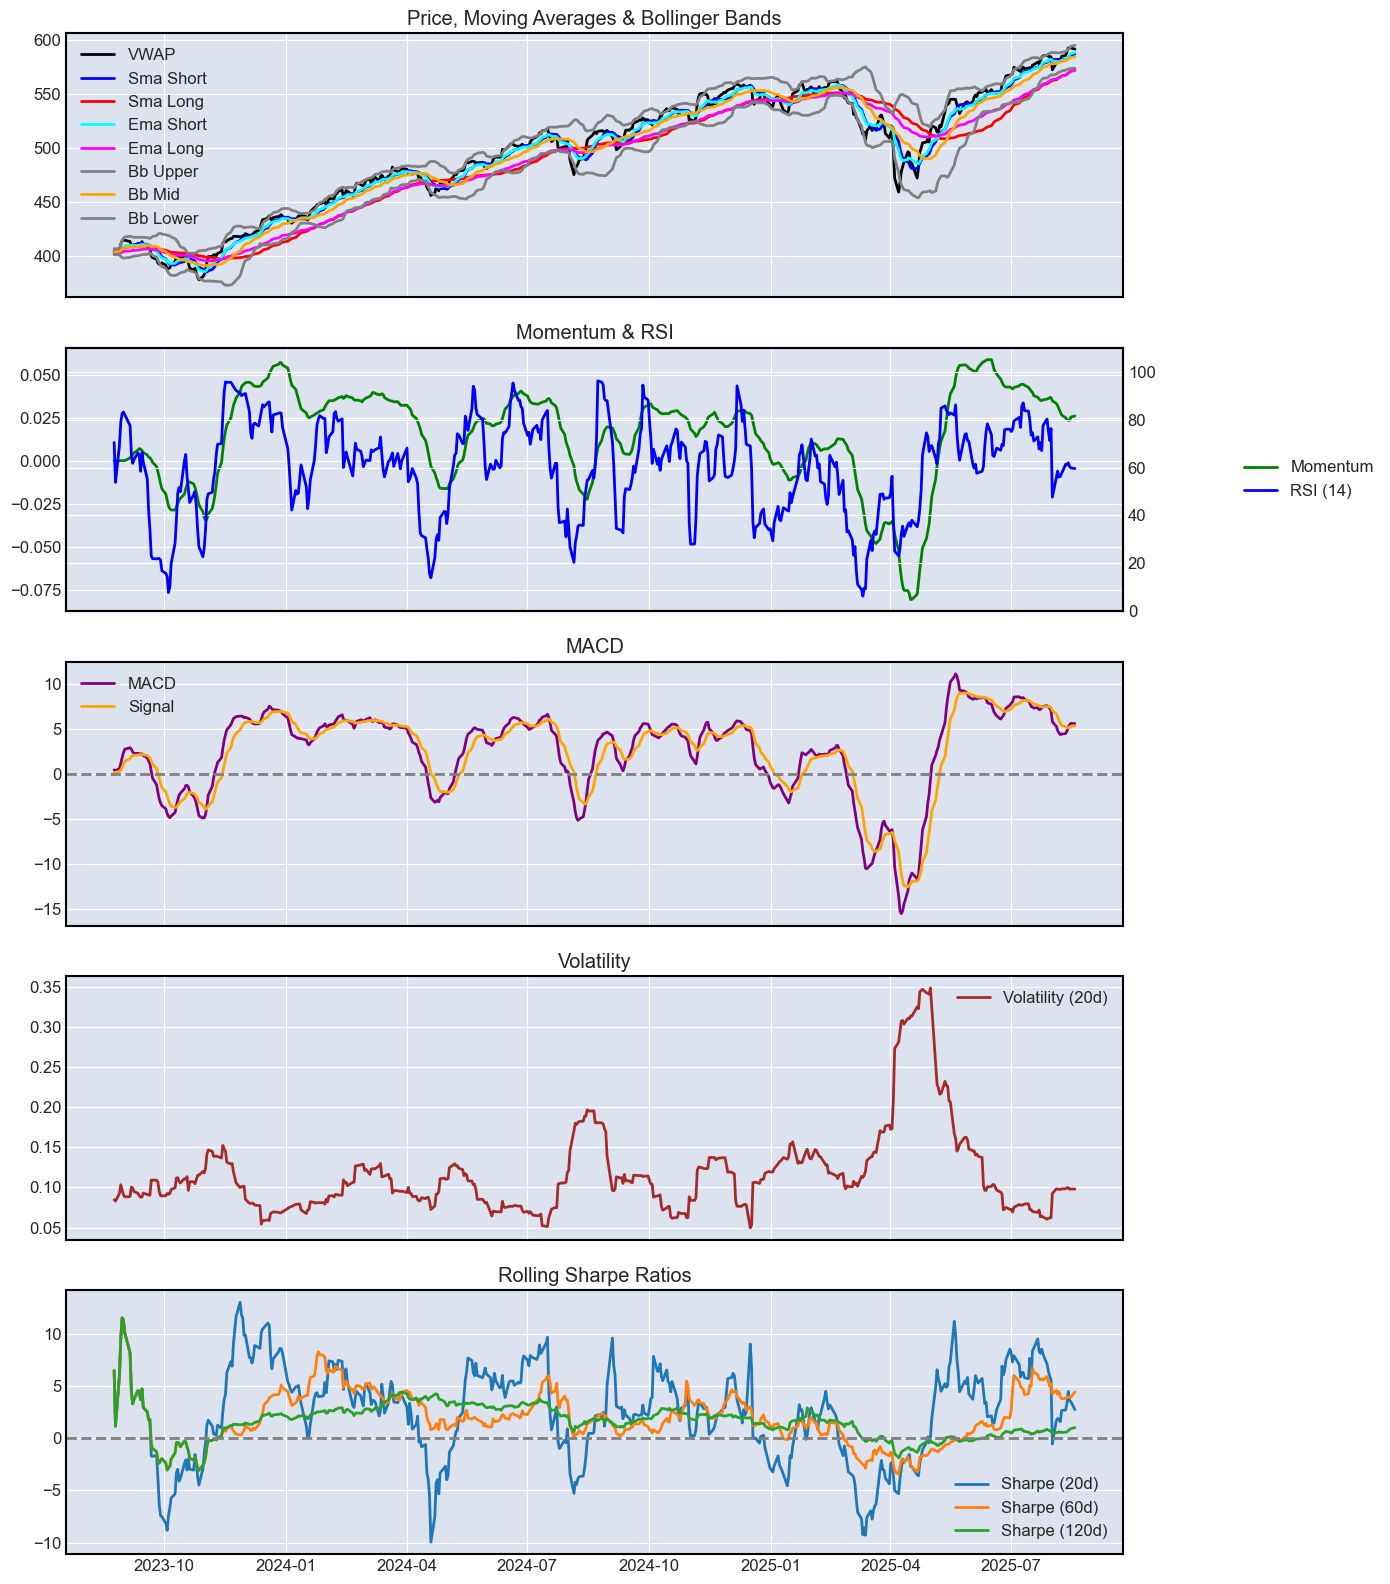

In [33]:
indicators = compute_indicators(historical_data, price_col='vw')
plot_indicators(indicators)